# Space Invader with dqn

## Step 1: Import the libraries

In [2]:
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('SpaceInvaders-v0')
env.seed(1)
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment
Execute the code cell below to play Space Invader with a random policy.

The size of frame is:  (210, 160, 3)
No. of Actions:  6


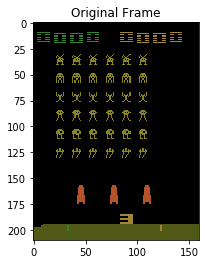

In [4]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

In [5]:
def random_play():
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        if done:
            env.close()
            break
random_play()

## Step 4:Preprocessing Frame

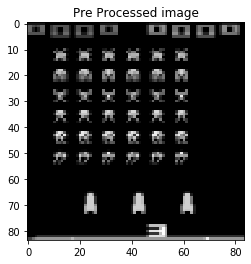

In [6]:
def preprocess_frame(screen):
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[8:-12, 4:-12]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (84, 84), interpolation = cv2.INTER_AREA)
    return screen

env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset()), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [7]:
def stack_frame(stacked_frames, state, is_new=False):
    frame = preprocess_frame(state)
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

## Step 6: Creating Replay Memory

In [8]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        
        states = torch.from_numpy(np.array([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences])).float().to(device)
        
        return (states, actions, rewards, next_states)

    def __len__(self):
        return len(self.memory)

## Step 7: Creating Deep Learning Model

In [9]:
class DQN(nn.Module):
    def __init__(self, num_actions=6):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)

## Step 8: Creating out agent

In [10]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 0.00025               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
class Agent():
    def __init__(self, action_size):
        self.action_size = action_size
        
        # Q-Network
        self.policy_net = DQN(action_size).to(device)
        self.target_net = DQN(action_size).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        
        # Replay memory
        self.memory = ReplayMemory(BUFFER_SIZE)
        
        self.t_step = 0
    
    def step(self, state, action, reward, next_state):
        # Save experience in replay memory
        self.memory.push(state, action, reward, next_state)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(BATCH_SIZE)
                self.learn(experiences, GAMMA)
                
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).unsqueeze(0).to(device)
        self.policy_net.eval()
        with torch.no_grad():
            action_values = self.policy_net(state)
        self.policy_net.train()
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next)

        # Get expected Q values from local model
        Q_expected = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.policy_net, self.target_net, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Step 9: Watching untrained agent play

In [12]:
agent = Agent(action_size= env.action_space.n)

# watch an untrained agent
state = stack_frame(None, env.reset(), True) 
for j in range(200):
    env.render()
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frame(state, next_state, False)
    if done:
        break 
        
env.close()

## Step 10: Loading Agent
Uncomment line to load a pretrained agent

In [15]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=100)

# To Load checkpoint uncomment code
# checkpoint = torch.load('space_invader_dqn.pth')
# agent.policy_net.load_state_dict(checkpoint['state_dict'])
# agent.target_net.load_state_dict(checkpoint['state_dict'])
# agent.optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# scores = checkpoint['socres']

# index = 1
# for i in reversed(scores):
#     scores_window.append(i)
#     if index == 100:
#         break
#     index += 1

## Step 11: Train the Agent with DQN

In [17]:
def train(n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    eps = eps_start
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frame(None, env.reset(), True)
        score = 0
        while True:
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frame(state, next_state, False)
            if done:
                reward = -100
            agent.step(state, action, reward, next_state)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            state = {'epoch': i_episode,'state_dict': agent.policy_net.state_dict(),'optimizer': agent.optimizer.state_dict(),
                     'socres': scores }
            torch.save(state, "space_invader_{}.pth".format(i_episode))
            files.download("space_invader_{}.pth".format(i_episode))
    
    return scores

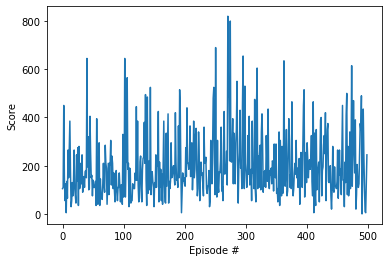

In [18]:
plt_scores = train(500)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(plt_scores)), plt_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 12: Watch a Smart Agent!

In [23]:
score = 0
state = stack_frame(None, env.reset(), True)
while True:
    env.render()
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frame(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()

You Final score is: 0.0


In [24]:
env.close()